# Intro

This project analyzes daily stock market data to visualize how the simple moving average (SMA) fluctuates over time.

## Install Dependencies

Install dependencies quietly, so logs don’t reveal sensitive info like absolute paths or user-specific details.

In [1]:
%pip install pandas polygon-api-client matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
from polygon import RESTClient
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

## Get Daily Aggregates

Use Polygon.io REST API to get daily aggregated bars. Docs: https://github.com/polygon-io/client-python

In [7]:
API_KEY = "<insert API key here>"
client = RESTClient(api_key=API_KEY)

In [4]:
def list_daily_aggregates(symbol, start_date, end_date):
    aggs = []
    for a in client.list_aggs(ticker=symbol, multiplier=1, timespan="day", from_=start_date, to=end_date, limit=50000):
        aggs.append(a)
    return aggs

def get_bars_as_dataframe(aggs):
    bars = pd.DataFrame([{
        "timestamp": a.timestamp,
        "open": a.open,
        "high": a.high,
        "low": a.low,
        "close": a.close,
        "volume": a.volume,
        "vwap": a.vwap,
        "transactions": a.transactions
    } for a in aggs])

    # Convert timestamp to datetime and set as index
    bars["date"] = pd.to_datetime(bars["timestamp"], unit="ms")
    bars.set_index("date", inplace=True)
    bars.drop(columns=["timestamp"], inplace=True)

    return bars.sort_index()

## Calculate and Plot Simple Moving Averages


In [5]:
def compute_smas(bars, max_window):
    # Compute all SMAs in range [1, max_window] into list of columns named "SMA_X"
    smas = []
    for w in range(1, max_window+1):
        smas.append(bars["close"].rolling(window=w).mean().rename(f"SMA_{w}"))

    # Concatenate columns into pd DataFrame only once to avoid memory fragmentation
    bars = pd.concat([bars] + smas, axis=1)
    return bars 

def plot_sma(symbol, bars, start_date, end_date, _list): 
    # Create canvas
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot closing price
    ax.plot(bars.index, bars["close"], color="black", alpha=0.4, label="Close")

    # Plot each SMA
    for w in _list:
        ax.plot(bars.index, bars[f"SMA_{w}"], label=f"SMA {w}")

    # Set x-axis range
    ax.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

    # Set y-axis range
    visible_data = bars.loc[start_date:end_date, [c for c in bars.columns if c=="close" or c.startswith("SMA")]]
    ymin = visible_data.min().min()
    ymax = visible_data.max().max()
    padding = 0.05 * (ymax - ymin)
    ax.set_ylim(ymin - padding, ymax + padding)

    # Define title and labels
    ax.set_title("{} - Simple Moving Averages".format(symbol))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()
    plt.show()

def plot_sma_gradient(symbol, bars, start_date, end_date, max_window=200):
    # Create canvas
    fig, ax = plt.subplots(figsize=(14, 6))

    # Create gradient, short-term SMA (red) -> long-term SMA (blue)
    red_to_blue = LinearSegmentedColormap.from_list(None, ["red", "blue"])
    norm = mcolors.Normalize(vmin=1, vmax=max_window)

    # Plot closing price
    ax.plot(bars.index, bars["close"], color="black", linewidth=1.5, zorder=10, label="Close")

    # Plot all SMAs in range [1, max_window]
    for w in range(1, max_window + 1):
        color = red_to_blue(norm(w))
        ax.plot(bars.index, bars[f"SMA_{w}"], color=color, linewidth=0.3, alpha=0.6)

    # Set x-axis range
    ax.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

    # Set y-axis range
    visible_data = bars.loc[start_date:end_date, [c for c in bars.columns if c=="close" or c.startswith("SMA")]]
    ymin = visible_data.min().min()
    ymax = visible_data.max().max()
    padding = 0.05 * (ymax - ymin)
    ax.set_ylim(ymin - padding, ymax + padding)
    
    # Define legend for SMAs
    sm = cm.ScalarMappable(cmap=red_to_blue, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label("SMA Window Size")

    # Define title and labels
    ax.set_title("{} - Simple Moving Averages".format(symbol))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()
    plt.show()

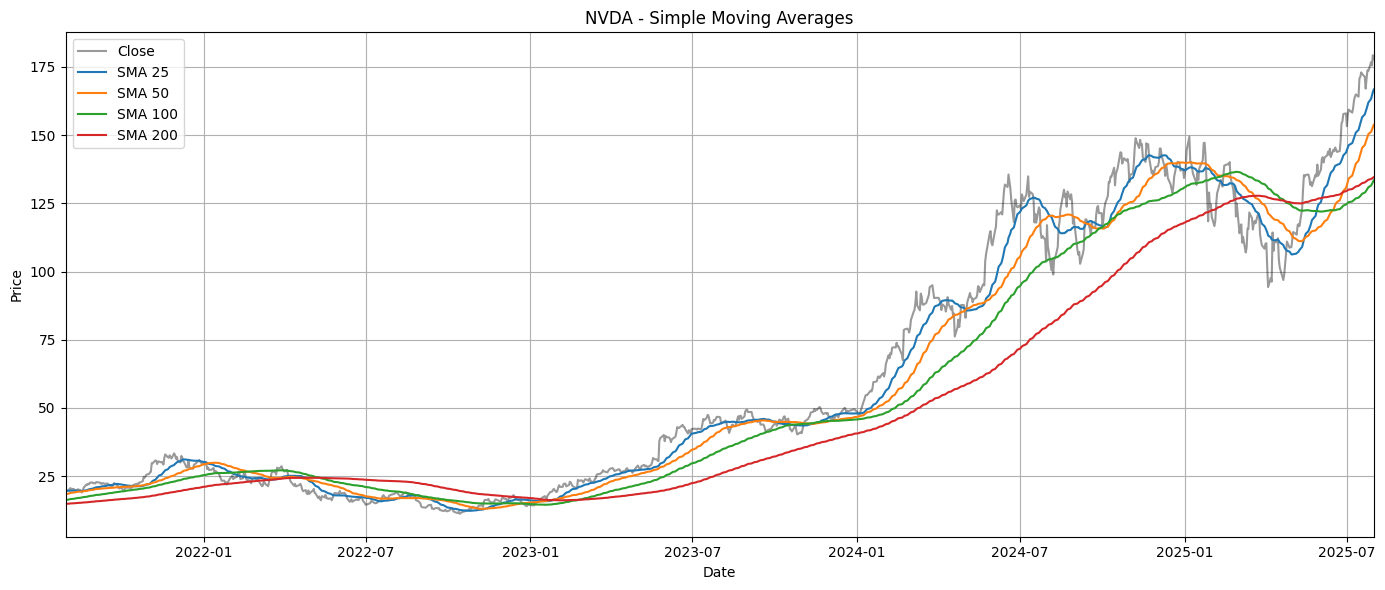

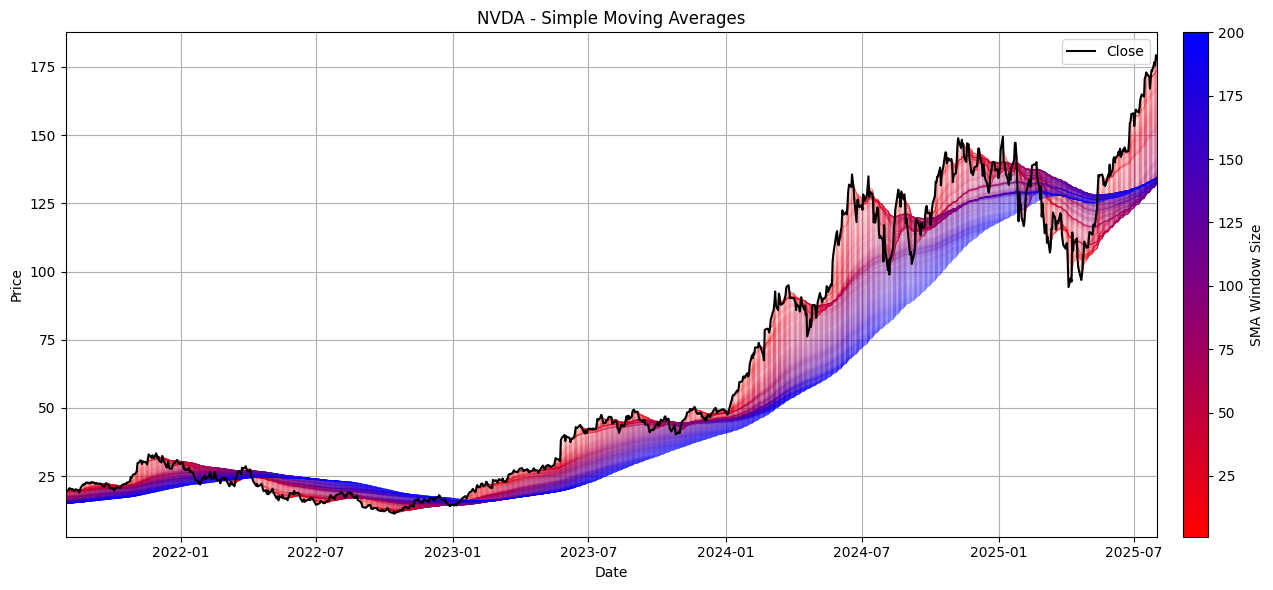

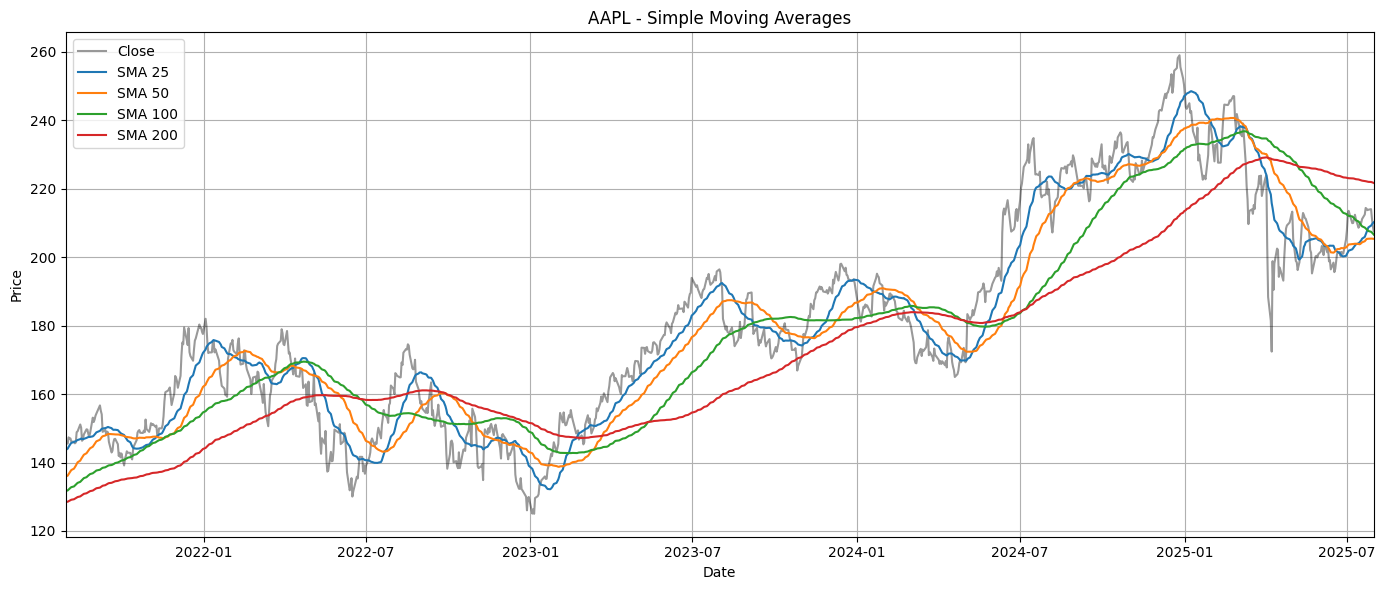

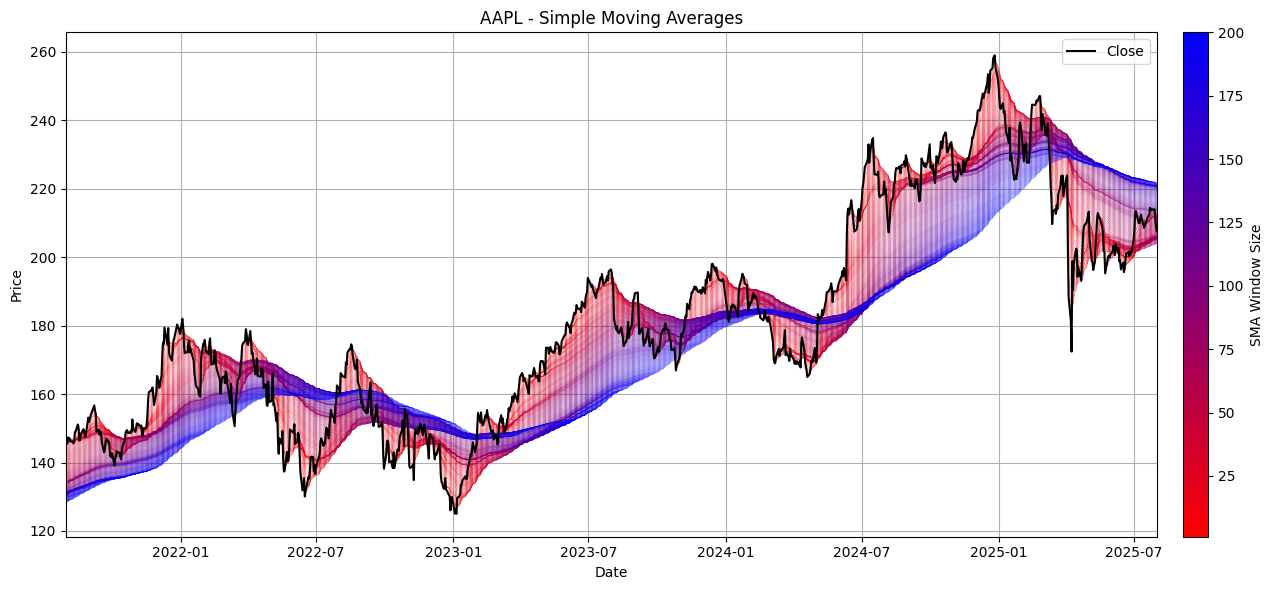

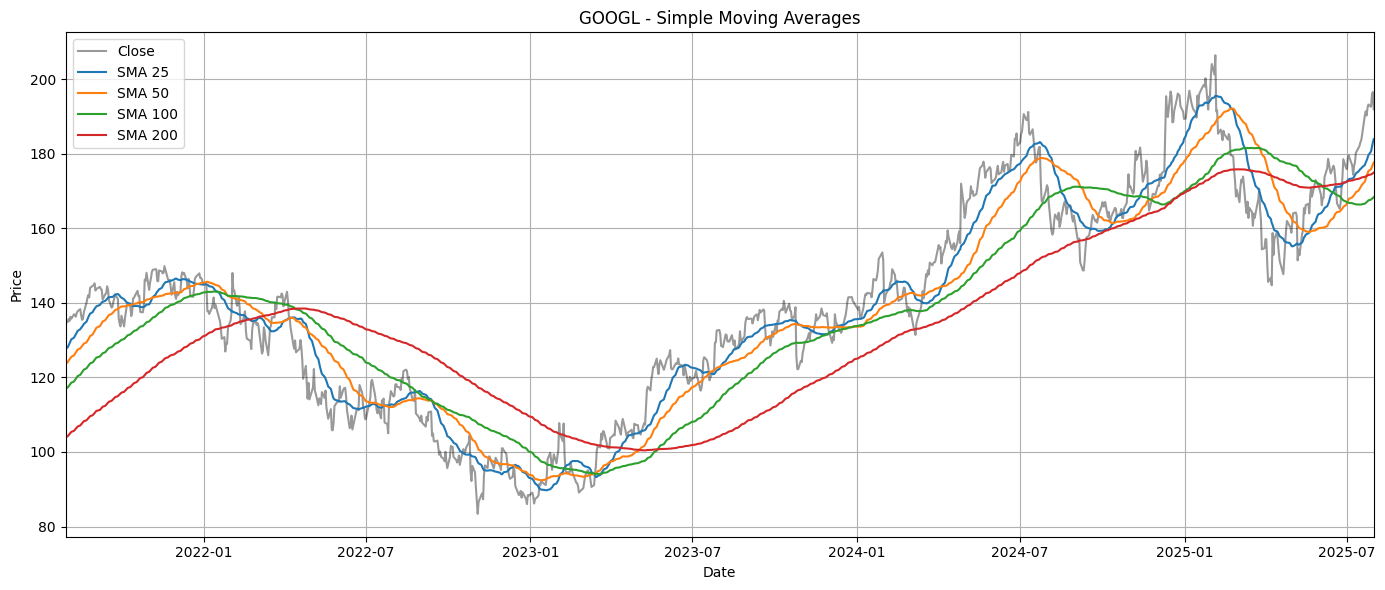

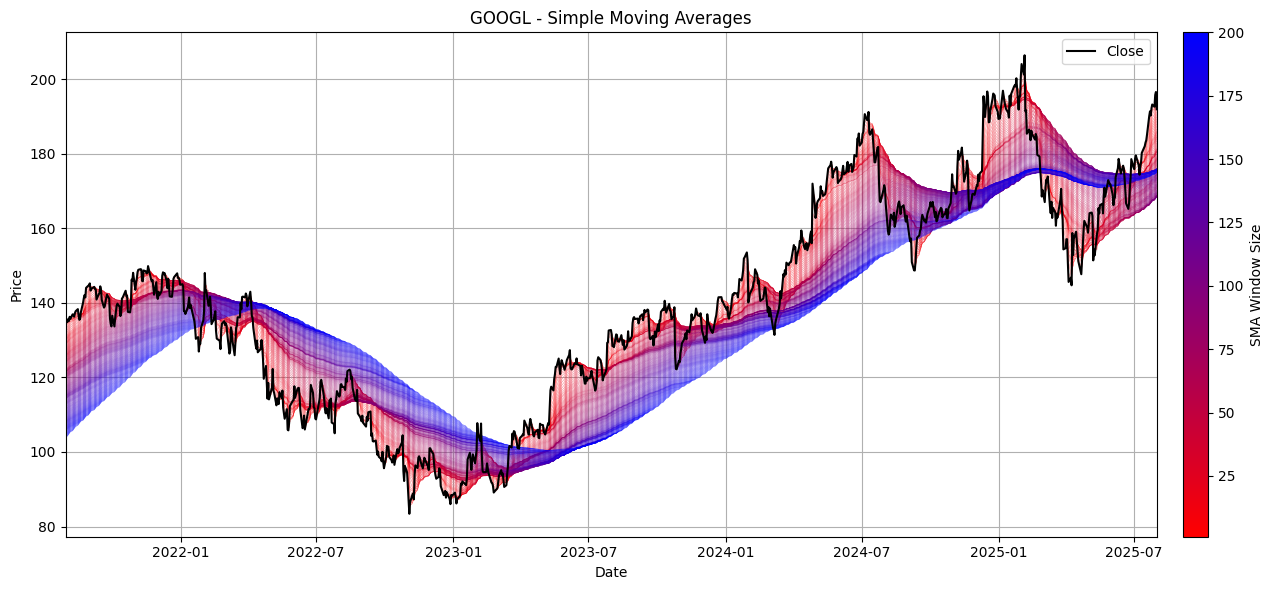

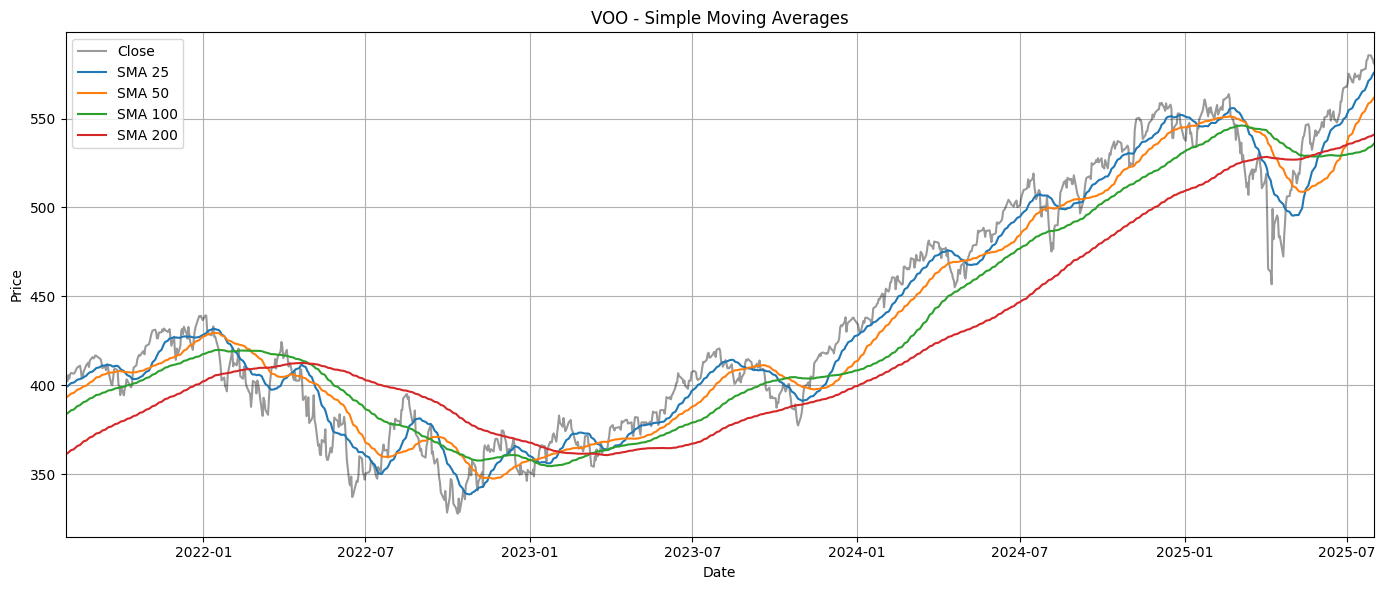

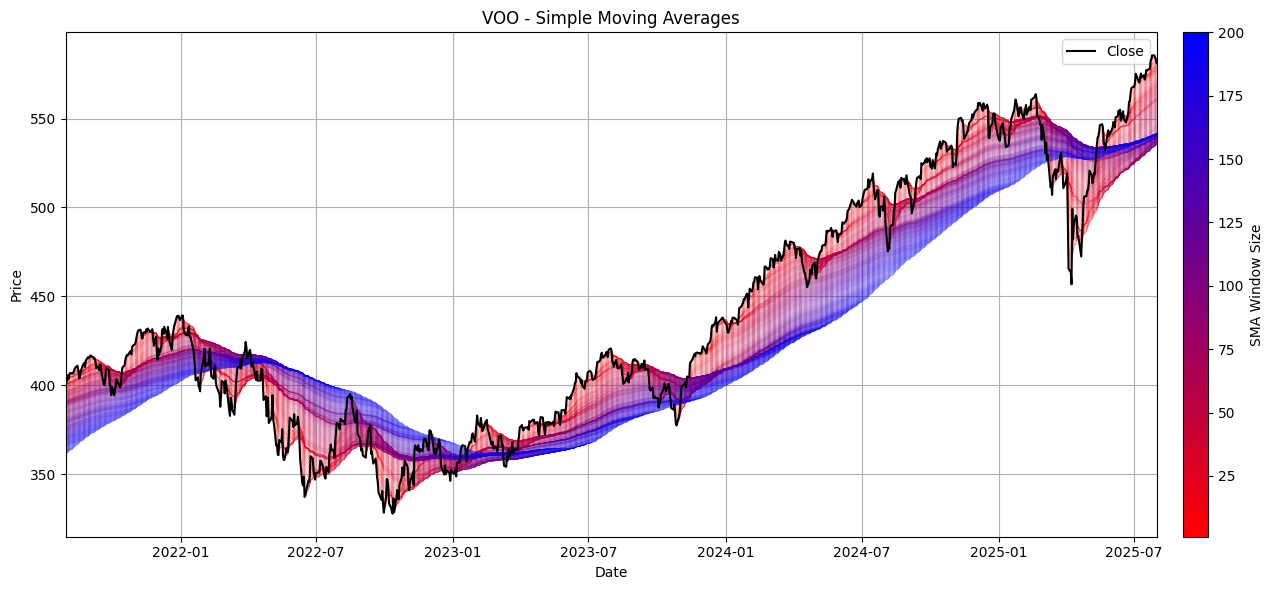

In [6]:
symbols = ["NVDA", "AAPL", "GOOGL", "VOO"]

for symbol in symbols:
    bars_start_date, bars_end_date = "2020-01-01", "2025-07-31"
    
    aggs = list_daily_aggregates(symbol, bars_start_date, bars_end_date)
    bars = get_bars_as_dataframe(aggs)

    bars = compute_smas(bars, 200)

    plot_start_date, plot_end_date = "2021-07-31", "2025-07-31"

    plot_sma(symbol, bars, plot_start_date, plot_end_date, [25, 50, 100, 200])
    plot_sma_gradient(symbol, bars, plot_start_date, plot_end_date, 200)